# **ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices**

Zhang, X., Zhou, X., Lin, M., & Sun, J. (2018). Shufflenet: An extremely efficient convolutional neural network for mobile devices. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 6848-6856).

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [75]:
def GConv_BN_ReLU(x, filters, groups, use_activation = True):
    x = tf.keras.layers.Conv2D(filters, 
                               1, 
                               groups = groups, 
                               strides = 1, 
                               padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if use_activation:
        x = tf.keras.layers.ReLU()(x)

    return x


def DWConv_BN_ReLU(x, filters, strides = 1):
    x = tf.keras.layers.Conv2D(filters, 
                               3, 
                               groups = x.shape[-1], 
                               strides = strides, 
                               padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x


class ChannelShuffle(tf.keras.layers.Layer):
    def __init__(self, groups):
        super(ChannelShuffle, self).__init__()
        self.groups = groups

    def call(self, x):
        return tf.concat([x[..., i::self.groups] for i in range(self.groups)], axis = -1)

In [76]:
def ShuffleNetUnits(
    x, 
    output_channels, 
    g = 3,
    is_not_stage_2_first_layer = True,
):
    assert x.shape[-1] <= output_channels, \
        "The size of the output dimension must be equal to or greater than the size of the input dimension."

    residual = x

    ## Strides applies only to 3x3 DWConv and 3x3 AVG Pool.
    if residual.shape[-1] < output_channels:
        strides = 2
        output_channels -= x.shape[-1] ## To maintain output channels even after concat.
    else:
        strides = 1

    x =  GConv_BN_ReLU(x, output_channels // 4, g if is_not_stage_2_first_layer else 1)
    x = ChannelShuffle(g)(x)
    x = DWConv_BN_ReLU(x, output_channels // 4, strides = strides)
    x =  GConv_BN_ReLU(x, output_channels, g, use_activation = False)

    ## If strides = 2, concat is applied instead of add.
    if strides == 2:
        residual = tf.keras.layers.AveragePooling2D(3, strides = 2, padding = "same")(residual)
        x = tf.keras.layers.Concatenate()([x, residual])
    else:
        x = tf.keras.layers.Add()([x, residual])
    
    x = tf.keras.layers.ReLU()(x)

    return x

In [77]:
IMAGE_SIZE = [224, 224] # Cropped ImageNet test size.

def create_NN(
    model_name,
    g = 3,
    num_classes = 1_000,
):
    """Base ResNet50"""
    x = model_input = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), dtype = tf.float32)

    ## Entry flow (stem).
    x = tf.keras.layers.Conv2D(24, 3, strides = 2, padding = "same")(x)
    x = tf.keras.layers.MaxPool2D(3, strides = 2, padding = "same")(x)

    ## Middle flow (Refers to variable name in DenseNet).
    assert g in [1, 2, 3, 4, 8], "Groups g must be in [144, 200, 240, 272, 383]."
    growth_rate = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}[g]

    for i, filter_multiplier in enumerate([1] * 4 + [2] * 8 + [4] * 4):
        x = ShuffleNetUnits(x, growth_rate * filter_multiplier, g, is_not_stage_2_first_layer = i)

    ## Exit flow.
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes)(x)

    model_output = x = tf.keras.layers.Softmax()(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [78]:
tmp = create_NN("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 112, 112, 24) 672         input_23[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 56, 56, 24)   0           conv2d_200[0][0]                 
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 56, 56, 54)   1350        max_pooling2d_20[0][0]           
________________________________________________________________________________________________

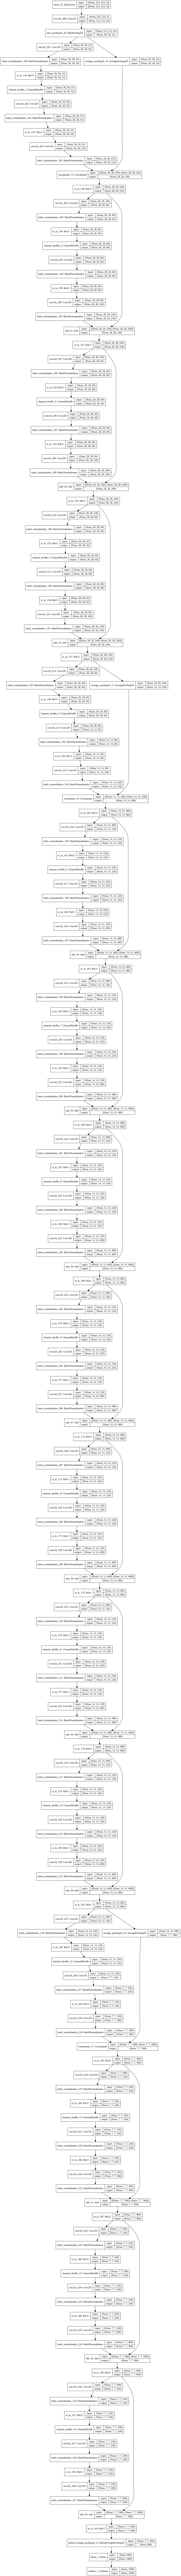

In [80]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [ ]:
del tmp